In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision.all import *

In [3]:
untar_data

<function fastai.data.external.untar_data>

**Fine Grain Classification**

In [4]:
path = untar_data(URLs.PETS)
path

Path('/root/.fastai/data/oxford-iiit-pet')

In [42]:
img_path=path/"images"

In [43]:
! ls $path/"annotations"

list.txt  README  test.txt  trainval.txt  trimaps  xmls


In [172]:
file=open(str(path/"annotations/trainval.txt"))
img_names=file.read()
img_names

'Abyssinian_100 1 1 1\nAbyssinian_101 1 1 1\nAbyssinian_102 1 1 1\nAbyssinian_103 1 1 1\nAbyssinian_104 1 1 1\nAbyssinian_105 1 1 1\nAbyssinian_106 1 1 1\nAbyssinian_107 1 1 1\nAbyssinian_108 1 1 1\nAbyssinian_109 1 1 1\nAbyssinian_10 1 1 1\nAbyssinian_110 1 1 1\nAbyssinian_111 1 1 1\nAbyssinian_112 1 1 1\nAbyssinian_113 1 1 1\nAbyssinian_114 1 1 1\nAbyssinian_115 1 1 1\nAbyssinian_116 1 1 1\nAbyssinian_117 1 1 1\nAbyssinian_118 1 1 1\nAbyssinian_119 1 1 1\nAbyssinian_11 1 1 1\nAbyssinian_120 1 1 1\nAbyssinian_121 1 1 1\nAbyssinian_122 1 1 1\nAbyssinian_123 1 1 1\nAbyssinian_124 1 1 1\nAbyssinian_125 1 1 1\nAbyssinian_126 1 1 1\nAbyssinian_127 1 1 1\nAbyssinian_128 1 1 1\nAbyssinian_129 1 1 1\nAbyssinian_12 1 1 1\nAbyssinian_130 1 1 1\nAbyssinian_131 1 1 1\nAbyssinian_132 1 1 1\nAbyssinian_133 1 1 1\nAbyssinian_134 1 1 1\nAbyssinian_135 1 1 1\nAbyssinian_136 1 1 1\nAbyssinian_137 1 1 1\nAbyssinian_138 1 1 1\nAbyssinian_139 1 1 1\nAbyssinian_13 1 1 1\nAbyssinian_140 1 1 1\nAbyssinian_14

In [173]:
len(img_names.split("\n"))

3681

In [174]:
img_names=list(map(lambda x:str(img_path)+"/"+x.split(" ",1)[0]+".jpg",img_names.split("\n")[:-1]))

In [175]:
len(img_names)

3680

In [176]:
img_names[-5:]

['/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_187.jpg',
 '/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_188.jpg',
 '/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_189.jpg',
 '/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_18.jpg',
 '/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_190.jpg']

In [177]:
count=0
for img_name in img_names:
  if img_name=='': count+=1
count

0

In [178]:
np.random.seed(2)

In [199]:
dblock=DataBlock(
                 blocks=(ImageBlock,CategoryBlock),
                 get_x=lambda x:x,  # this will be used at inference time also so it them general
                 get_y=lambda x:x.rsplit('/',1)[1].rsplit('_',1)[0],
                 item_tfms=Resize(224),
                 batch_tfms=Normalize(imagenet_stats)
)
dset=dblock.datasets(img_names)
dset[0]

(PILImage mode=RGB size=394x500, TensorCategory(0))

In [200]:
dls=dblock.dataloaders(img_names)

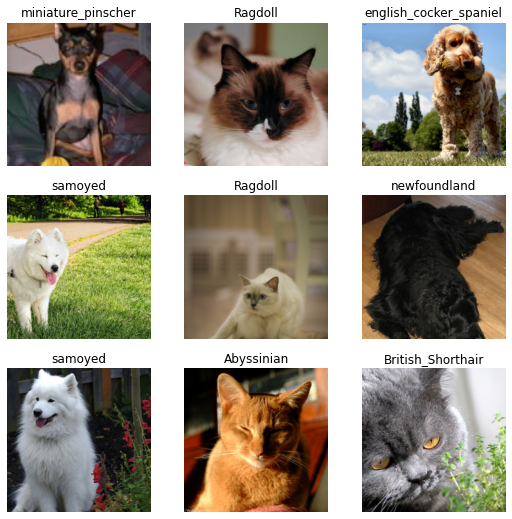

In [202]:
dls.show_batch()

In [203]:
dls.c # number of classes in single class classification

37

#Resnet34

In [204]:
learn=cnn_learner(dls,models.resnet34,metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [205]:
# lr_valley=learn.lr_find()

In [206]:
# lr_valley

In [207]:
learn.fit_one_cycle(n_epoch=4)

epoch,train_loss,valid_loss,error_rate,time
0,3.051878,0.552520,0.183424,00:25
1,1.319948,0.319351,0.108696,00:26
2,0.724471,0.279685,0.091033,00:25
3,0.474230,0.279821,0.089674,00:25


In [208]:
# learn.fit_one_cycle(lr_max=lr_valley,n_epoch=4)

In [209]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [210]:
interp=ClassificationInterpretation.from_learner(learn)

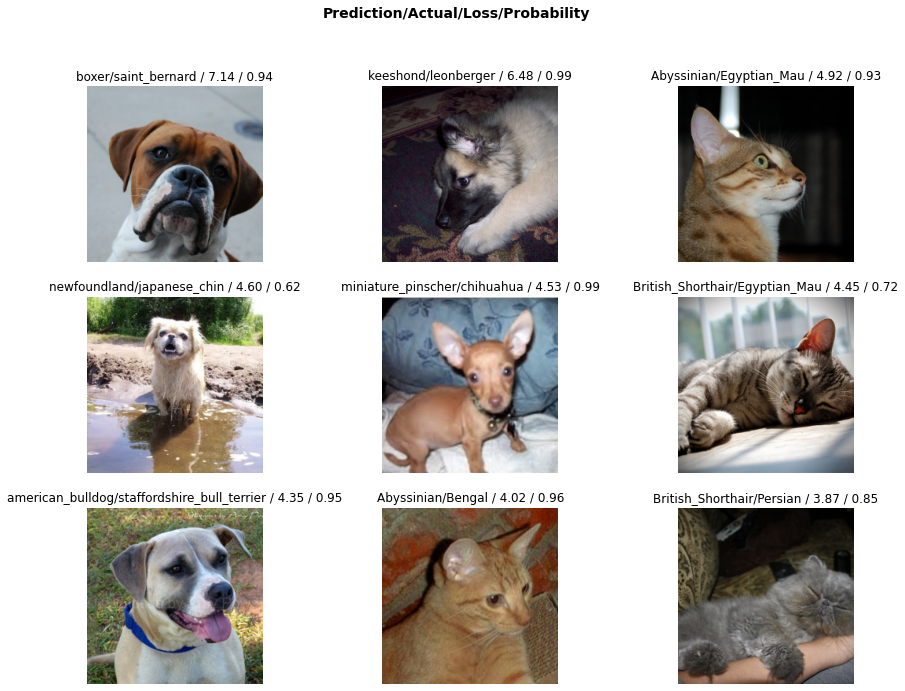

In [211]:
interp.plot_top_losses(9,figsize=(15,11))

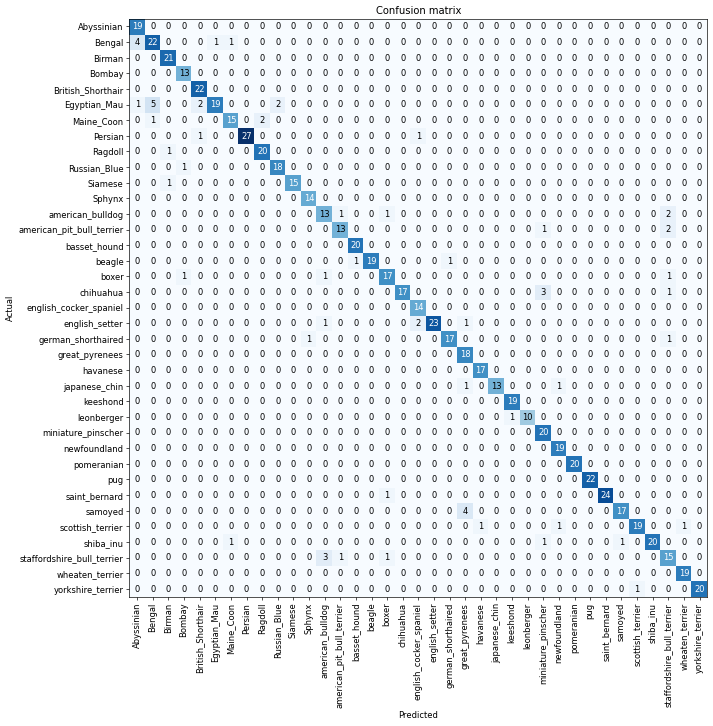

In [212]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [213]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 5),
 ('Bengal', 'Abyssinian', 4),
 ('samoyed', 'great_pyrenees', 4),
 ('chihuahua', 'miniature_pinscher', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Egyptian_Mau', 'British_Shorthair', 2),
 ('Egyptian_Mau', 'Russian_Blue', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 2),
 ('english_setter', 'english_cocker_spaniel', 2)]

In [214]:
learn.unfreeze()

In [215]:
# learn.lr_find()

In [216]:
learn.fit_one_cycle(4,lr_max=slice(5e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.315947,0.264600,0.084239,00:26
1,0.270041,0.257766,0.086957,00:26
2,0.220800,0.250569,0.081522,00:26
3,0.183745,0.252634,0.084239,00:26


In [217]:
learn.save("stage-2")

Path('models/stage-2.pth')

In [ ]:
learn.summary()

#Resnet50

In [84]:
dblock=DataBlock(
                 blocks=(ImageBlock,CategoryBlock),
                 get_x=lambda x:str(img_path/x)+".jpg",
                 get_y=lambda x:x.rsplit('_',1)[0],
                 item_tfms=Resize(299),
                 batch_tfms=Normalize(imagenet_stats)
)
dls=dblock.dataloaders(img_names,bs=32)

In [85]:
# dls.show_batch()

In [86]:
learn=cnn_learner(dls,models.resnet50,metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [87]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.937320,0.282062,0.097826,00:59
1,0.697831,0.309946,0.092391,00:57
2,0.361754,0.262110,0.080163,00:58
3,0.230421,0.190053,0.063859,00:57
4,0.143916,0.214513,0.062500,00:57
5,0.112134,0.196782,0.062500,00:57
6,0.082196,0.163695,0.046196,00:57
7,0.056031,0.159913,0.055707,00:57


In [90]:
learn.save('stage-1-50')

Path('models/stage-1-50.pth')

SuggestedLRs(valley=0.0002290867705596611)

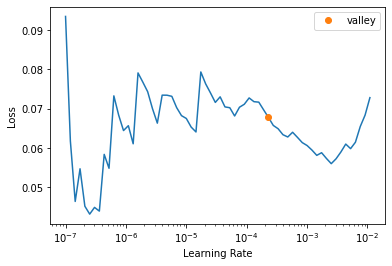

In [91]:
learn.lr_find()

In [93]:
learn.unfreeze()
learn.fit_one_cycle(3, lr_max=slice(1e-6,5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.077757,0.223716,0.073370,01:15
1,0.079303,0.160689,0.052989,01:14
2,0.049718,0.144198,0.047554,01:14


In [94]:
learn.save('stage-2-50')

Path('models/stage-2-50.pth')

In [95]:
interp=ClassificationInterpretation.from_learner(learn)

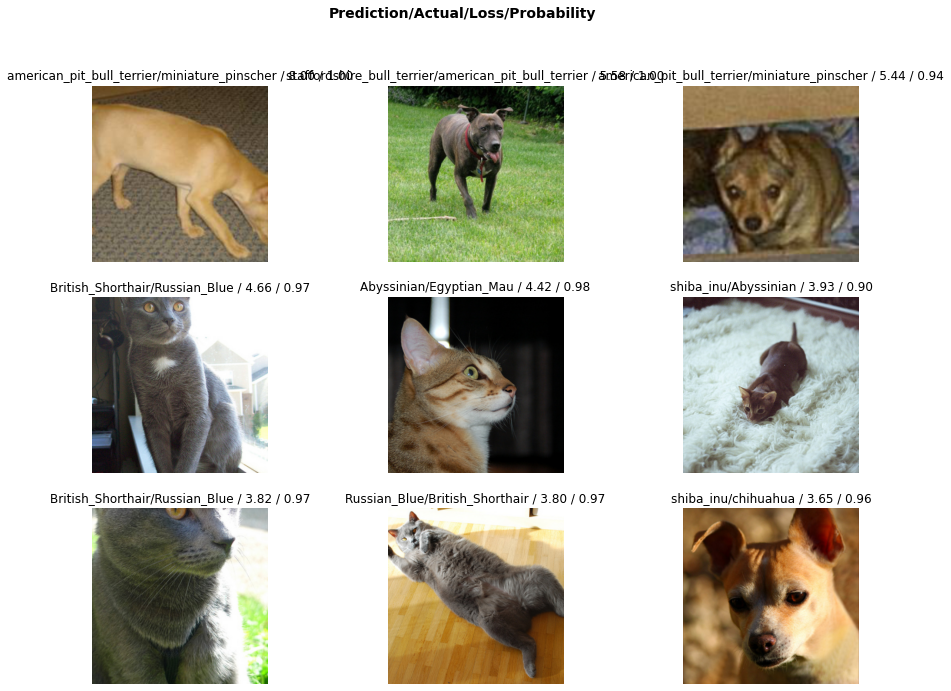

In [96]:
interp.plot_top_losses(9,figsize=(15,11))

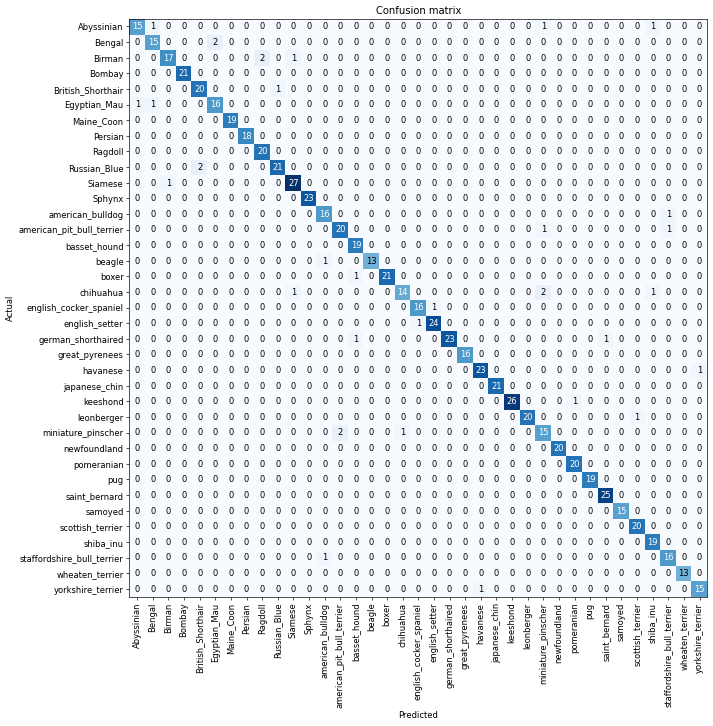

In [97]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [98]:
interp.most_confused(min_val=2)

[('Bengal', 'Egyptian_Mau', 2),
 ('Birman', 'Ragdoll', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2)]

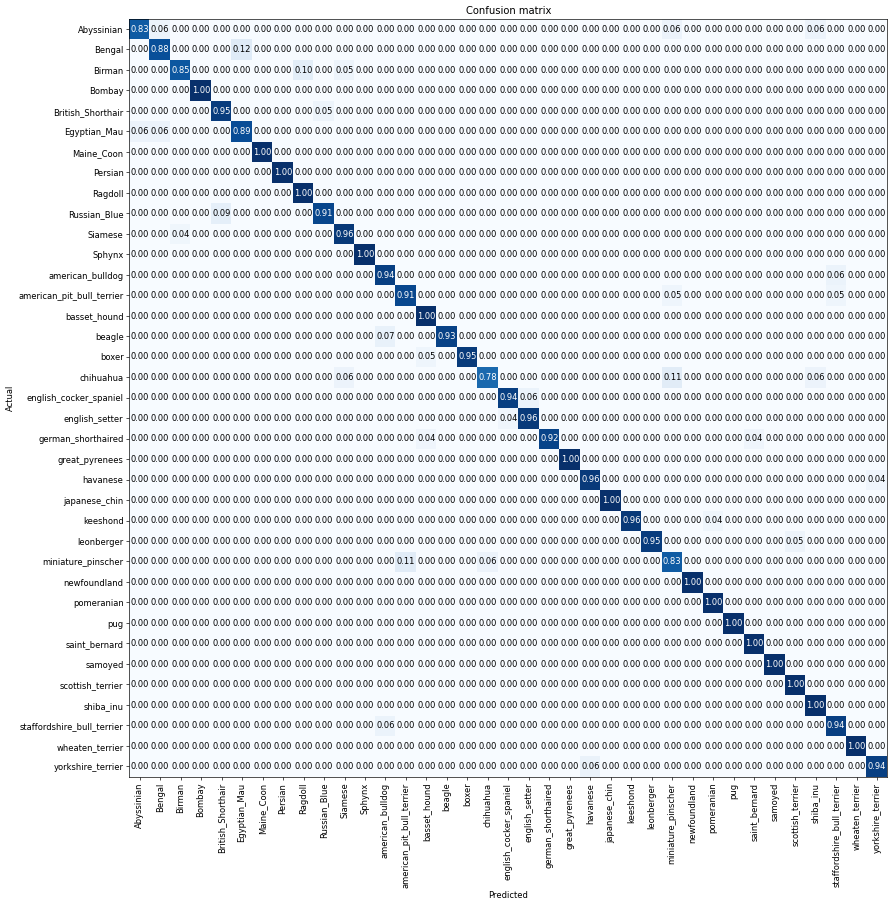

In [99]:
interp.plot_confusion_matrix(normalize=True,figsize=(15,15), dpi=60)

In [100]:
dls.train.__len__()

92

In [101]:
dls.valid.__len__()

23

In [102]:
img_labels=list(map(lambda x:x.rsplit("_",1)[0],img_names))
label_count={label:0 for label in np.unique(img_labels)}
for img_label in img_labels:
  label_count[img_label]+=1
label_count

{'Abyssinian': 100,
 'Bengal': 100,
 'Birman': 100,
 'Bombay': 96,
 'British_Shorthair': 100,
 'Egyptian_Mau': 93,
 'Maine_Coon': 100,
 'Persian': 100,
 'Ragdoll': 100,
 'Russian_Blue': 100,
 'Siamese': 99,
 'Sphynx': 100,
 'american_bulldog': 100,
 'american_pit_bull_terrier': 100,
 'basset_hound': 100,
 'beagle': 100,
 'boxer': 100,
 'chihuahua': 100,
 'english_cocker_spaniel': 96,
 'english_setter': 100,
 'german_shorthaired': 100,
 'great_pyrenees': 100,
 'havanese': 100,
 'japanese_chin': 100,
 'keeshond': 100,
 'leonberger': 100,
 'miniature_pinscher': 100,
 'newfoundland': 96,
 'pomeranian': 100,
 'pug': 100,
 'saint_bernard': 100,
 'samoyed': 100,
 'scottish_terrier': 100,
 'shiba_inu': 100,
 'staffordshire_bull_terrier': 100,
 'wheaten_terrier': 100,
 'yorkshire_terrier': 100}

In [103]:
# dls.train

In [104]:
dir(interp)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__stored_args__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'act',
 'confusion_matrix',
 'dl',
 'from_learner',
 'learn',
 'losses',
 'most_confused',
 'plot_confusion_matrix',
 'plot_top_losses',
 'print_classification_report',
 'show_results',
 'top_losses',
 'vocab']

In [105]:
interp.print_classification_report()

                            precision    recall  f1-score   support

                Abyssinian       0.94      0.83      0.88        18
                    Bengal       0.88      0.88      0.88        17
                    Birman       0.94      0.85      0.89        20
                    Bombay       1.00      1.00      1.00        21
         British_Shorthair       0.91      0.95      0.93        21
              Egyptian_Mau       0.89      0.89      0.89        18
                Maine_Coon       1.00      1.00      1.00        19
                   Persian       1.00      1.00      1.00        18
                   Ragdoll       0.91      1.00      0.95        20
              Russian_Blue       0.95      0.91      0.93        23
                   Siamese       0.93      0.96      0.95        28
                    Sphynx       1.00      1.00      1.00        23
          american_bulldog       0.89      0.94      0.91        17
 american_pit_bull_terrier       0.91      0.91

In [106]:
interp.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

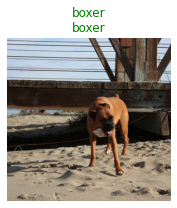

In [111]:
interp.show_results(4)

# Inference

In [253]:
import os 
import shutil
if os.path.exists("test/"):
  shutil.rmtree('test')
os.mkdir('test')

In [254]:
# learn.export()

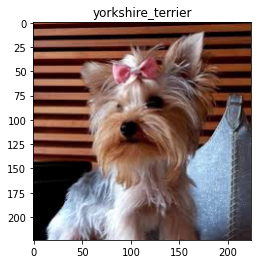

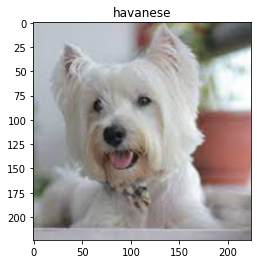

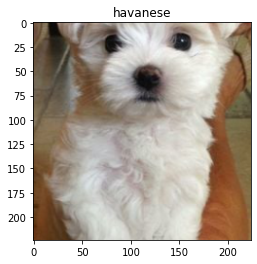

In [257]:
from glob import glob

test_list=glob("test/*")

for test_ex in test_list:
  pred=learn.predict(test_ex,with_input=True)
  plt.title(pred[1])
  plt.imshow(  pred[0].permute(1, 2, 0)  )
  plt.show()

In [252]:
interp.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']